# La régularisation par cohérence, ou l'art d'être constant avec soi-même

Fini la classification pour aujourd'hui ! On passe à la **segmentation**. Et pour ça, on va utiliser une des techniques les plus puissantes du SSL : la **régularisation par cohérence**. Le principe est d'une simplicité désarmante : un modèle doit donner des prédictions similaires pour la même image, même si celle-ci est vue sous différents angles (augmentations).

> Si vous reconnaissez votre chat qu'il soit à l'endroit, à l'envers ou un peu flou, votre modèle devrait en faire autant !

On va implémenter une architecture populaire qui utilise cette idée : le **Mean Teacher** (le prof moyen). Un modèle 'étudiant' apprend normalement, tandis qu'un modèle 'professeur' (plus stable) le guide. Le professeur n'est que la moyenne des poids passés de l'étudiant.

**Objectifs du jour :**
1. Changer de tâche : passer à la segmentation sur le dataset `Kvasir-SEG`.
2. Mettre en place des pipelines d'augmentations **faibles** et **fortes**.
3. Implémenter le modèle Mean Teacher.
4. Calculer une perte de supervision (sur les données étiquetées) et une perte de cohérence (sur les non étiquetées).
5. Visualiser les performances via l'évolution des pertes et le Dice Score.

On va utiliser seulement **50 images étiquetées** pour simuler un scénario réaliste où les masques de segmentation sont rares. Prêts pour la démo ?

## 1. Préparation pour la segmentation

On importe les bibliothèques nécessaires pour la segmentation, notamment des fonctions de perte comme le CrossEntropyLoss (adapté pour la segmentation multiclasse) et la librairie d'augmentation `albumentations` pour créer des transformations faibles et fortes.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

### 📦 Chargement du dataset

On utilise `Kvasir-SEG`, un dataset de segmentation de polypes du colon. On sélectionne **50 images étiquetées** pour simuler un scénario semi-supervisé réaliste, où les masques sont coûteux à obtenir.

In [2]:
# Custom Dataset class for Kvasir-SEG
class KvasirSegDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.jpg')])
        
        # Verify that images and masks match
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"
        for img_f, mask_f in zip(self.image_files, self.mask_files):
            assert img_f == mask_f, f"Mismatch: {img_f} != {mask_f}"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert('RGB'))  # Shape: (H, W, 3)
        mask = np.array(Image.open(mask_path).convert('L'))    # Shape: (H, W)
        
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 for background, 1 for polyp)
        
        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        return image, mask

### 🧪 Augmentations : le bon, la brute et le truand

On définit deux niveaux d'augmentation :
- **Faible (weak)** : pour le `teacher`, avec des transformations légères comme des flips horizontaux.
- **Forte (strong)** : pour le `student`, avec des transformations plus agressives (rotation, flou, cutout) pour le pousser à généraliser.

Un dataset custom gère ces deux pipelines : les données étiquetées reçoivent des augmentations fortes, les non étiquetées reçoivent les deux types.

In [3]:
# Augmentation pipelines with resize
IMG_SIZE = (384, 384)  # Fixed size for Kvasir-SEG
weak_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # RGB normalization
    ToTensorV2()
])

strong_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # RGB normalization
    ToTensorV2()
])

# Adapted MeanTeacherDataset for Kvasir-SEG
class MeanTeacherDataset(Dataset):
    def __init__(self, dataset, indices, weak_transform, strong_transform, is_labeled=True):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        img = np.asarray(img, dtype=np.uint8)  # Shape: (H, W, 3) or (3, H, W) if tensor
        mask = np.asarray(mask, dtype=np.uint8)  # Shape: (H, W) or (1, H, W) if tensor
        
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)

        # Check and reshape image to (H, W, 3)
        if isinstance(img, np.ndarray) and len(img.shape) == 3:
            if img.shape[0] == 3:  # Tensor-like (3, H, W)
                img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, 3)
            elif img.shape[2] != 3:  # Invalid channels
                raise ValueError(f"Image at index {idx} has invalid shape {img.shape}, expected (H, W, 3)")
        else:
            raise ValueError(f"Image at index {idx} has invalid shape {img.shape}, expected (H, W, 3)")

        # Check and reshape mask to (H, W)
        if isinstance(mask, np.ndarray):
            if len(mask.shape) == 3:
                if mask.shape[0] == 1:  # Tensor-like (1, H, W)
                    mask = mask.squeeze(0)  # Convert to (H, W)
                elif mask.shape[2] == 1:  # (H, W, 1)
                    mask = mask.squeeze(2)  # Convert to (H, W)
                else:
                    raise ValueError(f"Mask at index {idx} has invalid shape {mask.shape}, expected (H, W)")
            elif len(mask.shape) != 2:
                raise ValueError(f"Mask at index {idx} has invalid shape {mask.shape}, expected (H, W)")

        # Ensure image and mask have the same H, W
        if img.shape[:2] != mask.shape[:2]:
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_NEAREST)

        # Apply augmentations
        if not self.is_labeled:
            transformed_weak = self.weak_transform(image=img, mask=mask)
            transformed_strong = self.strong_transform(image=img, mask=mask)
            return transformed_weak['image'], transformed_strong['image']
        else:
            transformed = self.strong_transform(image=img, mask=mask)
            return transformed['image'], transformed['mask'].long()

/home/quillaur/jupyter_notebooks/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:

# Configuration du dataset
data_dir = '/home/quillaur/HDD-1TO/datasets/kvasir-seg/Kvasir-SEG'  # Replace with your dataset path
dataset = KvasirSegDataset(data_dir=data_dir, transform=None)  # No transform initially

# Split for SSL demo: 50 labeled, 100 test, rest unlabeled
train_size = len(dataset)
labeled_size = 50
test_size = 100
unlabeled_size = train_size - labeled_size - test_size
labeled_dataset, test_dataset, unlabeled_dataset = random_split(dataset, [labeled_size, test_size, unlabeled_size])

# Assign transform to test_dataset
test_dataset.dataset.transform = test_transform

# DataLoaders for MeanTeacherDataset
labeled_train_dataset = MeanTeacherDataset(dataset, labeled_dataset.indices, weak_transform, strong_transform, is_labeled=True)
unlabeled_train_dataset = MeanTeacherDataset(dataset, unlabeled_dataset.indices, weak_transform, strong_transform, is_labeled=False)

labeled_loader = DataLoader(labeled_train_dataset, batch_size=4, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_train_dataset, batch_size=16, shuffle=True)

# Print number of labeled, unlabeled, and test samples
print(f"Dataset loaded: {len(dataset)} samples | Labeled: {len(labeled_dataset)} | Unlabeled: {len(unlabeled_dataset)} | Test: {len(test_dataset)}")


Dataset loaded: 1000 samples | Labeled: 50 | Unlabeled: 850 | Test: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6392157..1.0].


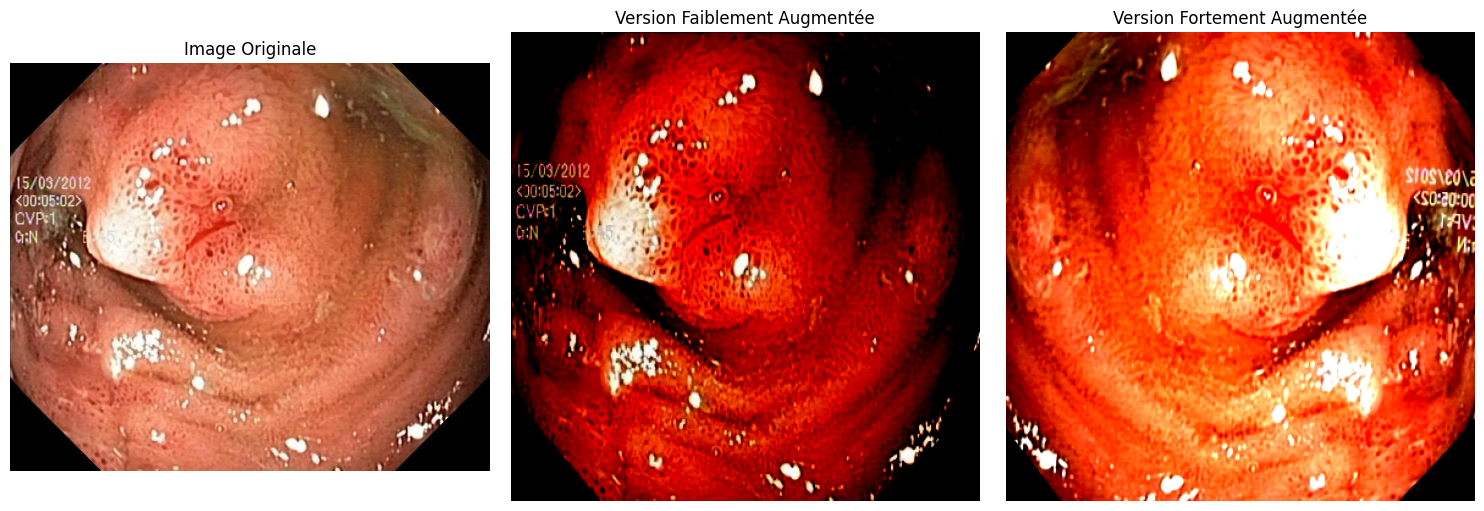

In [9]:
# Charger une image d'exemple
example_idx = 0
example_image = Image.open(os.path.join(dataset.image_dir, dataset.image_files[example_idx])).convert('RGB')
example_mask = Image.open(os.path.join(dataset.mask_dir, dataset.mask_files[example_idx])).convert('L')

# Appliquer les augmentations
weak_image = weak_transform(image=np.array(example_image))['image']
strong_image = strong_transform(image=np.array(example_image))['image']

# Visualiser
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(example_image)
axes[0].set_title('Image Originale')
axes[0].axis('off')
axes[1].imshow(weak_image.permute(1, 2, 0))
axes[1].set_title('Version Faiblement Augmentée')
axes[1].axis('off')
axes[2].imshow(strong_image.permute(1, 2, 0))
axes[2].set_title('Version Fortement Augmentée')
axes[2].axis('off')
plt.tight_layout()
plt.show()

## 2. Le modèle (student & teacher)

Pour la segmentation, on utilise une architecture de type U-Net simplifiée (pour la démo). On crée **deux instances** : `student` et `teacher`. Le `teacher` est une copie du `student`, mais ses poids sont mis à jour via une moyenne mobile exponentielle (EMA) pour plus de stabilité.

In [ ]:
# Device setup: Force CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Un U-Net très simple pour l'exemple
def simple_unet(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(16, out_channels, 1)
    )

def create_models(in_channels, out_channels):
    student = simple_unet(in_channels, out_channels).to(device)
    teacher = simple_unet(in_channels, out_channels).to(device)
    
    # Le teacher ne s'entraîne pas par backprop, on gèle ses poids
    for param in teacher.parameters():
        param.detach_()
        
    return student, teacher

# Création des modèles
in_channels = 3  # RGB images for Kvasir-SEG
out_channels = 2  # Binary segmentation (polyp vs. background)
student_model, teacher_model = create_models(in_channels, out_channels)
print('Modèles Student et Teacher prêts pour la démo !')

## 3. La boucle d'entraînement Mean Teacher

Voici le cœur de la démo ! À chaque époque :
1. Le `student` est entraîné sur les **données étiquetées** avec une perte supervisée (CrossEntropyLoss).
2. Les **données non étiquetées** passent par le `teacher` (augmentations faibles) et le `student` (augmentations fortes), et on calcule une **perte de cohérence** (MSE) entre leurs prédictions softmax.
3. La perte totale combine la perte supervisée et la perte de cohérence.
4. Le `teacher` est mis à jour via une moyenne mobile exponentielle (EMA) des poids du `student`.

On affiche les pertes à chaque époque et on trace leur évolution pour voir la progression.

In [ ]:

# Fonction pour mettre à jour le teacher via EMA
def update_teacher_model(student, teacher, alpha=0.99):
    """Mise à jour des poids du teacher par EMA : teacher = alpha * teacher + (1 - alpha) * student."""
    for teacher_param, student_param in zip(teacher.parameters(), student.parameters()):
        teacher_param.data.mul_(alpha)  # alpha * teacher_param
        teacher_param.data.add_((1 - alpha) * student_param.data)  # + (1 - alpha) * student_param

# Pertes
supervised_criterion = nn.CrossEntropyLoss()
consistency_criterion = nn.MSELoss()

# Optimiseur
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

# Paramètres d'entraînement
EPOCHS = 5
consistency_weight = 0.1  # Poids de la perte de cohérence

# Listes pour stocker les pertes par époque
epoch_sup_losses = []
epoch_con_losses = []

for epoch in tqdm(range(EPOCHS), desc='Entraînement Mean Teacher'):
    student_model.train()
    teacher_model.eval()  # Pas de backprop pour the teacher
    sup_losses = []
    con_losses = []
    
    # Itérer sur les deux loaders
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    num_batches = min(len(labeled_loader), len(unlabeled_loader))
    
    for _ in range(num_batches):
        try:
            labeled_imgs, masks = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            labeled_imgs, masks = next(labeled_iter)
        
        try:
            weak_unlabeled, strong_unlabeled = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            weak_unlabeled, strong_unlabeled = next(unlabeled_iter)
        
        labeled_imgs, masks = labeled_imgs.to(device), masks.to(device)
        weak_unlabeled, strong_unlabeled = weak_unlabeled.to(device), strong_unlabeled.to(device)
        
        optimizer.zero_grad()
        
        # 1. Perte supervisée
        pred_labeled = student_model(labeled_imgs)
        loss_sup = supervised_criterion(pred_labeled, masks)
        
        # 2. Perte de cohérence
        with torch.no_grad():
            teacher_preds = teacher_model(weak_unlabeled)
        student_preds = student_model(strong_unlabeled)
        
        # Calculer la perte de cohérence sur les probabilités
        loss_con = consistency_criterion(F.softmax(student_preds, dim=1), F.softmax(teacher_preds, dim=1))
        
        # 3. Perte totale
        total_loss = loss_sup + consistency_weight * loss_con
        
        total_loss.backward()
        optimizer.step()
        
        # 4. Mise à jour du teacher
        update_teacher_model(student_model, teacher_model)
        
        # Stocker les pertes
        sup_losses.append(loss_sup.item())
        con_losses.append(loss_con.item())
    
    # Calculer et stocker les pertes moyennes par époque
    epoch_sup_losses.append(np.mean(sup_losses))
    epoch_con_losses.append(np.mean(con_losses))

print(f'Époque {epoch+1}/{EPOCHS} - Perte Sup moyenne: {np.mean(sup_losses):.4f}, Perte Con moyenne: {np.mean(con_losses):.4f}')

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), epoch_sup_losses, label='Perte Supervisée', marker='o')
plt.plot(range(1, EPOCHS + 1), epoch_con_losses, label='Perte de Cohérence', marker='s')
plt.xlabel('Époque')
plt.ylabel('Perte moyenne')
plt.title('Évolution des pertes Supervisée et de Cohérence')
plt.legend()
plt.grid(True)
plt.show()

## 4. Évaluation

On évalue le `teacher_model` (plus stable grâce à l'EMA) sur le jeu de test avec le **Dice Score**, une métrique clé en segmentation. On s'attend à ce que la régularisation par cohérence améliore les performances par rapport à un modèle entraîné uniquement sur les 20 images étiquetées.

In [ ]:

# Fonction pour calculer le Dice score (adapted for binary segmentation)
def dice_score(pred, target, smooth=1e-8):
    pred = F.softmax(pred, dim=1)[:, 1, :, :]  # Probability for polyp class (1)
    target = target.float()  # Binary mask (0 or 1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Evaluation on test set
teacher_model.eval()
total_dice = 0
test_loader_eval = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, masks in test_loader_eval:
        images, masks = images.to(device), masks.to(device)
        outputs = teacher_model(images)
        total_dice += dice_score(outputs, masks).item()

avg_dice = total_dice / len(test_loader_eval)
print(f'Dice Score moyen sur le jeu de test : {avg_dice:.3f}')


## 5. Visualisation des prédictions

Pour mieux comprendre les performances, visualisons quelques prédictions du `teacher_model` sur le jeu de test, avec les images, les masques ground truth, et les masques prédits.

In [ ]:

# Visualiser quelques prédictions
num_examples = 4
test_subset = Subset(test_dataset, range(num_examples))
test_loader_viz = DataLoader(test_subset, batch_size=num_examples, shuffle=False)

teacher_model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader_viz))
    images, masks = images.to(device), masks.to(device)
    outputs = teacher_model(images)
    preds = F.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy()
    images = images.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5  # Denormalize RGB
    masks = masks.cpu().numpy()

fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))
for i in range(num_examples):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[i], cmap='gray')
    axes[i, 1].set_title('Masque Ground Truth')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(preds[i], cmap='gray')
    axes[i, 2].set_title('Masque Prédit')
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

## 6. Questions de réflexion

La démo montre comment le Mean Teacher exploite les données non étiquetées via la régularisation par cohérence. Observez les courbes de pertes : la perte de cohérence diminue-t-elle, signe que le `student` devient cohérent avec le `teacher` ? Le Dice Score est-il compétitif pour seulement 20 images étiquetées ?

**Questions pour réfléchir :**
1. **Le rôle de `alpha`** : Le coefficient d'EMA `alpha=0.99` rend le `teacher` stable. Que se passerait-il avec un `alpha` faible (ex: 0.5) ? Testez pour voir !
2. **Augmentations fortes vs. faibles** : Pourquoi les augmentations fortes pour le `student` sont-elles cruciales ? Que se passe-t-il si on utilise les mêmes augmentations pour les deux ?
3. **Ramp-up de la perte de cohérence** : La perte de cohérence est-elle utile dès le début, quand le modèle est peu entraîné ? Essayez un `consistency_weight` qui augmente progressivement (ex: de 0 à 0.1 sur 10 époques).